### HEALPix Regridding Test
Andrew Gettelman
February 2025

In [1]:
## Standard Stuff
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import dask.array as da
#import numcodecs

## HEALPix Specific
import healpix as hp
import easygems.healpix as egh
import easygems.remap as egr

import intake     # For catalogs
import zarr       # Data Formatting


/home/users/mmuetz/miniforge3/envs/regrid2hp_env/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
plt.rcParams['figure.figsize'] = [12, 8]

### Read SCREAM HEALPix Data

In [5]:
opth='/global/cfs/cdirs/m4549/scream-cess-healpix/'

var='rlut'
vart='OLR'
varu='(Wm$^{-2}$)'

/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


CPU times: user 1.69 s, sys: 1.19 s, total: 2.88 s
Wall time: 3.43 s


Text(0.5, 1.0, 'SCREAM OLR 2020-01-05 00:00 HEALPix Level 10 (6km)')

<Figure size 1200x800 with 0 Axes>

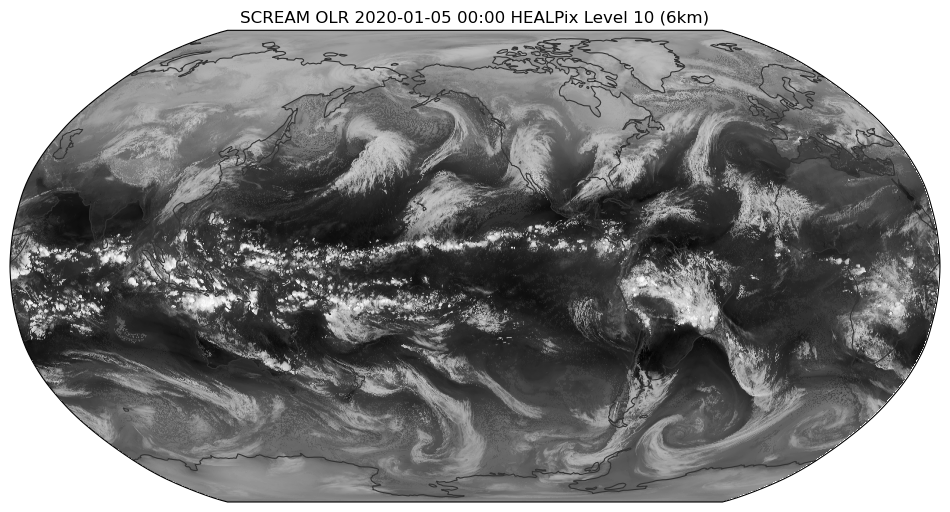

In [45]:
%%time
#s='6'; dkm='100'
#s='8'; dkm='25'
s='10' ; dkm='6'

res=' ('+dkm+'km)'

ofn=opth+"scream2D_hrly_"+var+"_hp"+s+"_v6.zarr"

ds=xr.open_dataset(ofn)

# Add coordinates (lat and lon)
ds=ds.pipe(egh.attach_coords)

tm='2020-01-05 00:00'
egh.healpix_show(ds[var].sel(time=tm)[0],cmap='binary')
plt.title('SCREAM '+vart+' '+tm+' HEALPix Level '+s+res)

In [13]:
ds

<xarray.Dataset> Size: 476GB
Dimensions:  (time: 9457, cell: 12582912)
Coordinates:
  * time     (time) object 76kB 2019-08-01 00:00:00 ... 2020-09-01 00:00:00
    crs      int64 8B 0
  * cell     (cell) int64 101MB 0 1 2 3 ... 12582908 12582909 12582910 12582911
    lat      (cell) float64 101MB 0.0373 0.0746 0.0746 ... -0.0746 -0.0373
    lon      (cell) float64 101MB 45.0 45.04 44.96 45.0 ... 315.0 315.0 315.0
Data variables:
    rlut     (time, cell) float32 476GB ...
Attributes: (12/22)
    Conventions:                  CF-1.8
    atm_initial_conditions_file:  /lustre/orion/cli115/world-shared/e3sm/inpu...
    averaging_frequency:          1
    averaging_frequency_units:    nhours
    averaging_type:               INSTANT
    case:                         cess-control.ne1024pg2_ne1024pg2.F2010-SCRE...
    ...                           ...
    product:                      model-output
    realm:                        atmos
    run_t0:                       2019-08-01-00000
    source:                       E3SM Atmosphere Model (EAMxx)
    topography_file:              /lustre/orion/cli115/world-shared/e3sm/inpu...
    username:                     noel

### Regrid to 1x1 lat-lon (or at least generate the weights to do so)

In [51]:
%%time
# Find the HEALPix pixels that are closest to the 1x1 degree grid points.
# Can do with either hpz6 or hpz10 data...(here high res as an example)

lon = np.arange(0, 360, 1)
lat = np.arange(90, -91, -1)
pix = xr.DataArray(
    hp.ang2pix(ds.crs.healpix_nside, *np.meshgrid(lon, lat), nest=True, lonlat=True),
    coords=(("lat", lat), ("lon", lon)),
)

# Plot the 1x1 world map for a given variable and time.
#ds[var].drop_vars(["lat", "lon"]).isel(cell=pix).sel(time=tm).plot(cmap='Greys')

regrid=ds[var].drop_vars(["lat", "lon"]).sel(time=tm).isel(cell=pix)

CPU times: user 44.5 ms, sys: 103 ms, total: 148 ms
Wall time: 149 ms


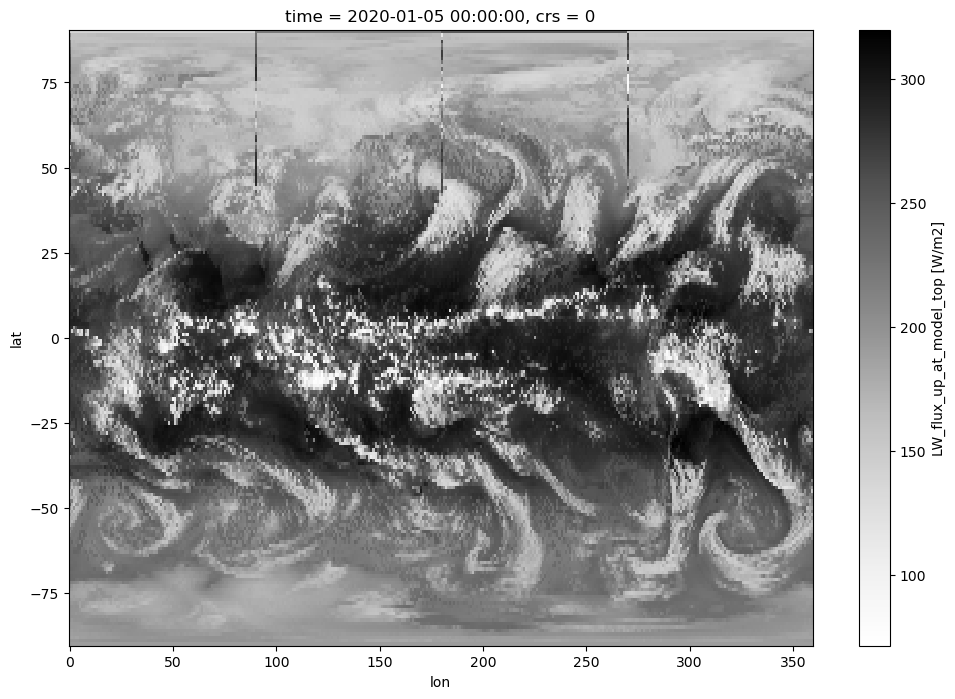

In [52]:
regrid.plot(cmap='Greys')